In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import zscore
import ray
from flaml import AutoML


In [2]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [3]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [4]:
df_train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000
mean,94.480458,1990.876367,1.359443,103.840110,0.0,2590.328333
std,24.082642,12.141435,0.042505,0.071627,0.0,714.910468
min,34.000000,1966.000000,1.270380,103.685228,0.0,300.000000
25%,73.000000,1981.000000,1.330939,103.778803,0.0,2100.000000
50%,93.000000,1988.000000,1.354024,103.845301,0.0,2400.000000
75%,110.000000,2000.000000,1.386968,103.897418,0.0,3000.000000
max,215.000000,2019.000000,1.457071,103.964915,0.0,6950.000000


In [5]:
df_train.columns

Index(['rent_approval_date', 'town', 'block', 'street_name', 'flat_type',
       'flat_model', 'floor_area_sqm', 'furnished', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'monthly_rent'],
      dtype='object')

In [6]:
def category_map(df_origin, df_train_):
    df = df_origin.copy()
    df_train_ = df_train_.copy()
    colums = ['town', 'flat_type', 'flat_type2', 'cluster', 'street_name', 'block',
              'lease_commence_date', 'flat_model', 'subzone', 'planning_area','region']
    #locations = ['town', 'block', 'street_name', 'subzone', 'planning_area','region', 'cluster']
    
    for col in colums:
        group_mean = df_train_.groupby(col)['monthly_rent'].mean()
        group_std = df_train_.groupby(col)['monthly_rent'].std()
        group_median = df_train_.groupby(col)['monthly_rent'].median()
        group_cnt = pd.value_counts(df_train_[col])
        total_mean = df_train_['monthly_rent'].mean()
        total_median = df_train_['monthly_rent'].median()
        total_std = df_train_['monthly_rent'].std()
        cat_map = group_mean.index
        std_map = group_std.to_dict()
        mean_map = group_mean.to_dict()
        median_map = group_median.to_dict()
        sqrt_cnt_map = group_cnt.apply(lambda x: np.sqrt(x)).to_dict()
        #if col in locations:
        df[col+'_std'] = df[col].apply(lambda x: std_map[x] + np.random.normal(loc=0.0, scale=2.0/sqrt_cnt_map[x]) if x in cat_map else 0)
        #else:
        df[col+'_mean'] = df[col].apply(lambda x: mean_map[x] + np.random.normal(loc=0.0, scale=2.0/sqrt_cnt_map[x]) if x in cat_map else total_mean)
        df[col+'_median'] = df[col].apply(lambda x: median_map[x] + np.random.normal(loc=0.0, scale=2.0/sqrt_cnt_map[x]) if x in cat_map else total_median)

        #df.drop(columns=[col], inplace=True)
        

    return df


In [7]:
train_block = df_train['street_name'].unique()
test_block = df_test['street_name'].unique()
print(set(test_block) - set(train_block))

{"jalan ma'mor"}


In [8]:
#add KNN feature
def add_KNN_feature(df_origin, df_pos, K: int):
    KNN_X = df_pos[['latitude', 'longitude']]
    #KNN_X['latitude'] *= 2
    KNN_y = df_pos['monthly_rent']

    KNN_model = KNeighborsRegressor(n_neighbors=K)
    KNN_model.fit(KNN_X, KNN_y)

    KNN_y2 = KNN_y ** 2
    KNN_model2 = KNeighborsRegressor(n_neighbors=K)
    KNN_model2.fit(KNN_X, KNN_y2)

    predict_X = df_origin[['latitude', 'longitude']]
    #predict_X['latitude'] *= 2
    predict_y = KNN_model.predict(predict_X)
    predict_y2 = KNN_model2.predict(predict_X)
    df = df_origin.copy()
    #use std to be the feature
    df['K=' + str(K) + ' KNN_std'] = np.sqrt(predict_y2 - predict_y ** 2)
    #df['K=' + str(K) + ' KNN_mean'] = predict_y

    return df

In [9]:
def data_preprocess(df, df_train_, category_mapping=True):
    df = df.copy()
    df_train_ = df_train_.copy()

    df['flat_type2'] = df['flat_type'].str.replace('-', ' ')
    df_train_['flat_type2'] = df_train_['flat_type'].str.replace('-', ' ')
    
    #normalize by date
    #df['monthly_rent'] = np.log(df['monthly_rent'])
    #df_train_['monthly_rent'] = np.log(df_train_['monthly_rent'])
    means = df_train_.groupby('rent_approval_date')['monthly_rent'].mean()
    stds = df_train_.groupby('rent_approval_date')['monthly_rent'].std()
    median = df_train_.groupby('rent_approval_date')['monthly_rent'].median()

    df['monthly_rent'] = df.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    df_train_['monthly_rent'] = df_train_.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    #normalize monthly rent by date

    #df['rent_approval_date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    #df['rent_approval_date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    
    #add coe price
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe['date'] = pd.to_datetime(df_coe['date'])
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()
    avg_price_bids_quota['date'] = pd.to_datetime(avg_price_bids_quota['date'])

    df['coe_price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    
    if category_mapping:
        df = category_map(df, df_train_)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)


    
    for K in [16, 32, 64, 128]:
        df = add_KNN_feature(df, df_train_, K)
    
    df['date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    df['date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    df['date_median'] = df['rent_approval_date'].apply(lambda x: median[x])

    for col in df.columns:
        #change -1 to KNN K=8
        if df[col].dtype == 'float64':
            df[col] = df[col].apply(lambda x: df[col][df[col] != -1].mean() if x == -1 else x)
    
    
    #df.drop(['latitude'], axis=1, inplace=True)
    #df.drop(['longitude'], axis=1, inplace=True)
    #df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date']).astype('int64')
    df.drop(['rent_approval_date'], axis=1, inplace=True)
    #df.drop(['block'], axis=1, inplace=True)

    return df

In [10]:
def handle_outliers(group, attribute):
    z_scores = zscore(group[attribute])
    threshold = 3 
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    print(len(outlier_indices))
    return group[(z_scores < threshold)]  

In [11]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')
df_test['monthly_rent'] = -1
#df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date']).astype('int64')
#df_test['rent_approval_date'] = pd.to_datetime(df_test['rent_approval_date']).astype('int64')

In [12]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


In [13]:
# handle outlier
grouped = df_train.groupby('rent_approval_date', group_keys=False)
df_train = grouped.apply(handle_outliers, attribute='monthly_rent')
df_train.reset_index(drop=True, inplace=True)

16
6
16
12
15
6
13
9
6
6
8
13
3
2
5
9
11
6
17
1
15
10
5
5
7
7
5
9
5
7
7


<Axes: xlabel='latitude', ylabel='longitude'>

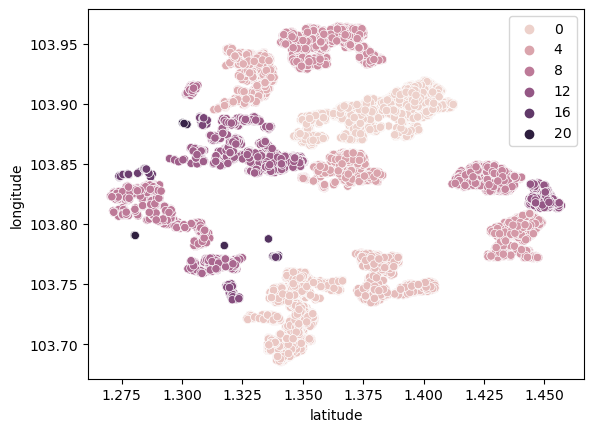

In [14]:
#add cluster feature
df_lat_long = df_train[['latitude', 'longitude']]
df_lat_long_test = df_test[['latitude', 'longitude']]
df_total = pd.concat([df_lat_long, df_lat_long_test], axis=0)
from sklearn.cluster import DBSCAN
DBSCAN_model = DBSCAN(eps=0.005, min_samples=1)
DBSCAN_model.fit(df_total)
#plot
sns.scatterplot(x='latitude', y='longitude', hue=DBSCAN_model.labels_, data=df_total)


In [15]:
df_train['cluster'] = DBSCAN_model.labels_[:len(df_train)]
df_test['cluster'] = DBSCAN_model.labels_[len(df_train):]

In [16]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,cluster
0,2021-01,sengkang,407b,fernvale road,5 room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,0
1,2021-01,sengkang,313b,Anchorvale Road,5 room,premium apartment,110.0,yes,2003,1.391349,103.888012,0.0,anchorvale,sengkang,north-east region,2100,0
2,2021-01,jurong west,657a,Jurong West Street 65,4 room,model a,91.0,yes,2002,1.335413,103.700289,0.0,jurong west central,jurong west,west region,2150,1
3,2021-01,choa chu kang,484a,Choa Chu Kang Avenue 5,4 room,model a2,90.0,yes,1999,1.376685,103.736818,0.0,peng siang,choa chu kang,west region,2000,2
4,2021-01,jurong west,661c,Jurong West Street 64,5 room,improved,110.0,yes,2001,1.336077,103.705050,0.0,jurong west central,jurong west,west region,2950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59790,2023-07,jurong west,975,jurong west street 93,4-room,model a,105.0,yes,1989,1.340241,103.693550,0.0,yunnan,jurong west,west region,4000,1
59791,2023-07,yishun,331,Yishun Ring Road,4-room,model a,104.0,yes,1988,1.430613,103.843054,0.0,yishun east,yishun,north region,3350,7
59792,2023-07,queenstown,31,Ghim Moh Link,4-room,model a,93.0,yes,2018,1.309604,103.784023,0.0,ghim moh,queenstown,central region,4500,8
59793,2023-07,geylang,102,aljunied crescent,3-room,new generation,82.0,yes,1978,1.320481,103.882473,0.0,aljunied,geylang,central region,750,11


In [17]:
ds_train_processed = data_preprocess(df_train, df_train)
ds_train_unmapped = data_preprocess(df_train, df_train, category_mapping=False)
#ds_test_processed = data_preprocess(df_test, df_train)
#ds_test_unmapped = data_preprocess(df_test, df_train, category_mapping=False)
ds_train_processed

,floor_area_sqm,latitude,longitude,monthly_rent,coe_price,town_std,town_mean,town_median,flat_type_std,flat_type_mean,...,region_std,region_mean,region_median,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,date_mean,date_std,date_median
0,110.0,1.388997,103.875148,-0.116219,45187.375,0.867414,0.073710,0.010237,0.949165,0.397005,...,0.893919,-0.075259,-0.134216,0.576671,0.724513,0.739432,0.720515,2142.604268,366.587073,2100.0
1,110.0,1.391349,103.888012,-0.116219,45187.375,0.838026,0.039164,0.021235,0.945762,0.423386,...,0.887044,-0.054773,-0.124149,0.747911,0.863253,0.820683,0.788476,2142.604268,366.587073,2100.0
2,91.0,1.335413,103.700289,0.020175,45187.375,0.988420,0.089190,0.108026,0.947197,0.173869,...,0.990049,-0.043407,-0.101220,1.077009,0.964903,0.896131,0.876252,2142.604268,366.587073,2100.0
3,90.0,1.376685,103.736818,-0.389005,45187.375,0.867031,-0.155092,-0.209132,0.954878,0.189927,...,0.991274,-0.028502,-0.076370,0.649760,0.744889,0.784018,0.830630,2142.604268,366.587073,2100.0
4,110.0,1.336077,103.705050,2.202466,45187.375,0.989871,0.085562,0.101621,0.945931,0.419031,...,0.980777,-0.026723,-0.099709,0.718599,0.702743,0.834438,0.826835,2142.604268,366.587073,2100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59790,105.0,1.340241,103.693550,0.925308,104442.375,0.978666,0.106364,0.101408,0.962386,0.167010,...,1.002150,-0.039831,-0.088642,0.900919,0.939026,1.065622,0.940717,3256.823760,803.166361,3250.0
59791,104.0,1.430613,103.843054,0.116011,104442.375,0.942115,-0.327233,-0.380112,0.962570,0.164540,...,0.916815,-0.231347,-0.292255,0.724437,0.769427,0.819457,0.909829,3256.823760,803.166361,3250.0
59792,93.0,1.309604,103.784023,1.547844,104442.375,1.217304,0.457336,0.345620,0.951403,0.153041,...,1.137716,0.234478,0.138225,1.013883,0.917894,1.121017,1.162651,3256.823760,803.166361,3250.0
59793,82.0,1.320481,103.882473,-3.121176,104442.375,1.100722,-0.136613,-0.271147,0.790749,-0.532683,...,1.135611,0.248447,0.147549,1.162607,1.089344,0.889005,0.883303,3256.823760,803.166361,3250.0


In [18]:
# attributes = ds_train_processed.keys()[ds_train_processed.keys() != 'rent_approval_date']
# grouped = ds_train_processed.groupby('rent_approval_date')
# for attribute in attributes:
#     ds_train_processed = grouped.apply(handle_outliers, attribute=attribute)

In [19]:
ds_train_processed.describe()

,floor_area_sqm,latitude,longitude,monthly_rent,coe_price,town_std,town_mean,town_median,flat_type_std,flat_type_mean,...,region_std,region_mean,region_median,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,date_mean,date_std,date_median
count,59795.000000,59795.000000,59795.000000,5.979500e+04,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,...,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000
mean,94.422686,1.359627,103.840182,1.930984e-17,75185.622197,0.963913,-0.000049,-0.058588,0.887425,-0.000075,...,0.983856,0.000011,-0.068162,0.779240,0.826690,0.862893,0.892534,2584.139142,564.773729,2550.061042
std,24.075897,0.042422,0.071683,9.997491e-01,21312.333087,0.097419,0.249630,0.247794,0.093569,0.451265,...,0.090796,0.152962,0.134169,0.182950,0.149540,0.127839,0.112822,389.376818,166.114930,409.877526
min,34.000000,1.270380,103.685228,-4.577843e+00,43812.000000,0.748485,-0.410279,-0.447049,0.599901,-1.887188,...,0.867910,-0.296348,-0.334176,0.265654,0.426418,0.481109,0.628708,2142.604268,366.587073,2100.000000
25%,73.000000,1.331122,103.778700,-7.158524e-01,52199.625000,0.896967,-0.202944,-0.257891,0.793343,-0.520546,...,0.909203,-0.063891,-0.116350,0.654478,0.724833,0.775173,0.814980,2244.716619,409.331849,2200.000000
50%,93.000000,1.354222,103.845493,-7.932483e-02,77035.625000,0.934010,0.025942,-0.042259,0.942354,0.174901,...,0.943070,-0.030430,-0.093100,0.762352,0.812298,0.848954,0.878301,2432.078749,528.611405,2400.000000
75%,110.000000,1.387045,103.897547,6.510527e-01,96230.250000,1.016341,0.112937,0.081623,0.954190,0.391943,...,1.002100,-0.003597,-0.072754,0.887278,0.914106,0.936564,0.955247,3059.300292,778.595583,3050.000000
max,192.000000,1.457071,103.964915,3.090164e+00,105592.375000,1.451633,0.945563,0.818324,1.010399,0.634577,...,1.170260,0.280354,0.176434,1.635501,1.563811,1.576526,1.528629,3256.823760,803.166361,3250.000000


In [20]:
df_norm = df_train.copy()
#df_norm['monthly_rent'] = np.log(df_norm['monthly_rent'])
means = df_norm.groupby('rent_approval_date')['monthly_rent'].mean()
stds = df_norm.groupby('rent_approval_date')['monthly_rent'].std()

In [21]:
X = ds_train_processed.drop(['monthly_rent'], axis=1)
#X.drop(['rent_approval_date'], axis=1, inplace=True)
y = df_train['monthly_rent'] - means[df_train['rent_approval_date']].reset_index(drop=True)
#X = X[best_features]
#X_cat = ds_train_unmapped.drop(['monthly_rent'], axis=1)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#real_X_train, real_X_test, real_y_train, real_y_test = train_test_split(df_train, real_y, test_size=0.3, random_state=42)





In [22]:
lgbm_best_params = {"n_estimators": 984, "num_leaves": 14, "min_child_samples": 20, "learning_rate": 0.00955415404855802, "log_max_bin": 9, "colsample_bytree": 0.1715233882278872, "reg_alpha": 0.014850297149652449, "reg_lambda": 133.998563158583}

xgb_best_params = {"n_estimators": 1916, "max_leaves": 41, "min_child_weight": 2.801525277874866, "learning_rate": 0.008298317608896174, "subsample": 0.6353412977381421, "colsample_bylevel": 0.41285744272632785, "colsample_bytree": 0.28604232010408714, "reg_alpha": 0.0011682284135139422, "reg_lambda": 5.118367390261997}

cat_best_params = {"early_stopping_rounds": 10, "learning_rate": 0.0357338948551828, "n_estimators": 230}

In [23]:
#ray.init(num_cpus=32, ignore_reinit_error=True)
#np.setbufsize(4096)
#np.getbufsize()

In [24]:
config = {
    "time_limits": 3600, # in seconds
    "early_stop": False,
    "max_threads": 4, # threads for each learner
    "parallel_trail": 8, # trails in parallel
    "log_postfix": 'trial0.log',
    "eval_method": 'cv',
}

automl_settings_lightgbm = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['lgbm'],
    "eval_method": config['eval_method'],
    "log_file_name": 'lgbm_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_xgboost = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['xgboost'],
    "eval_method": config['eval_method'],
    "log_file_name": 'xgboost_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_randomforest = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['rf'],
    "eval_method": config['eval_method'],
    "log_file_name": 'rf_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_extra_tree = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['extra_tree'],
    "eval_method": config['eval_method'],
    "log_file_name": 'extra_tree_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_catboost = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['catboost'],
    "eval_method": config['eval_method'],
    "log_file_name": 'catboost_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

#randomforest_automl = AutoML()

#randomforest_automl.fit(X_train=X, y_train=y, **automl_settings_randomforest)

#extra_tree_automl = AutoML()

#extra_tree_automl.fit(X_train=X, y_train=y, **automl_settings_extra_tree)

#lightgbm_automl = AutoML()

#lightgbm_automl.fit(X_train=X, y_train=y, **automl_settings_lightgbm)#, starting_points=lgbm_best_params)

catboost_automl = AutoML()

catboost_automl.fit(X_train=X, y_train=y, **automl_settings_catboost)#, starting_points=cat_best_params)

xgboost_automl = AutoML()

xgboost_automl.fit(X_train=X, y_train=y, **automl_settings_xgboost)#, starting_points=xgb_best_params)



(train pid=34312) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit


In [ ]:
#plot importance of xgboost
feature_importance = xgboost_automl.model.estimator.feature_importances_
#feature_importance = lightgbm_automl.model.estimator.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance_df

,feature,importance
3,coe_price,3800
37,K=16 KNN_std,3457
41,date_mean,3441
2,longitude,3287
21,block_median,3041
1,latitude,2873
20,block_mean,2853
17,street_name_mean,2689
18,street_name_median,2551
42,date_std,2414


In [ ]:

df_test['monthly_rent'] = 0

ds_test_processed = data_preprocess(df_test, df_train)
ds_test_processed.drop(['monthly_rent'], axis=1, inplace=True)
#ds_test_processed.drop(['rent_approval_date'], axis=1, inplace=True)
y_pred_catboost = catboost_automl.predict(ds_test_processed)
y_pred_xgboost = xgboost_automl.predict(ds_test_processed)
#y_pred_lightgbm = lightgbm_automl.predict(ds_test_processed)



In [ ]:
y_pred_catboost = y_pred_catboost + means[df_test['rent_approval_date']].reset_index(drop=True)
y_pred_xgboost = y_pred_xgboost + means[df_test['rent_approval_date']].reset_index(drop=True)
#y_pred_lightgbm = y_pred_lightgbm + means[df_test['rent_approval_date']].reset_index(drop=True)

In [ ]:

submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = y_pred_catboost
submission.to_csv('submission_catboost.csv', index=False)
submission['Predicted'] = y_pred_xgboost
submission.to_csv('submission_xgboost.csv', index=False)
#submission['Predicted'] = y_pred_lightgbm
#submission.to_csv('submission_lightgbm.csv', index=False)
submission['Predicted'] = ((y_pred_catboost ** 2 + y_pred_xgboost ** 2) / 2) ** 0.5
submission.to_csv('submission_ensemble_square.csv', index=False)
submission['Predicted'] = ((y_pred_catboost + y_pred_xgboost) / 2)
submission.to_csv('submission_ensemble_mean.csv', index=False)
submission['Predicted'] = ((y_pred_catboost * y_pred_xgboost) ** 0.5)
submission.to_csv('submission_ensemble_geometric.csv', index=False)
submission['Predicted'] = 2 / (1.0 / y_pred_catboost + 1.0 / y_pred_xgboost)
submission.to_csv('submission_ensemble_harmonic.csv', index=False)
